Plot the distribution of GMM

In [1]:
%matplotlib inline
import sys
import os
import json
from glob import glob

import numpy as np
import torch
import dill
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.animation as animation

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
sys.path.append('..')
sys.path.append('../../../trajectron')
sys.path.append('../../../..')
sys.path.append(PYTHONAPI_EGG_PATH)

import utility as util
from helper import load_model, prediction_output_to_trajectories
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

from model.components.discrete_latent import DiscreteLatent

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

Search for CARLA datasets

In [2]:
search_datasets = False
dataset_dir = '../../../..'
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

In [3]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset with bitmap mis-matched from NuScenes",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)
    
dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset = dataset_5
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.


Load NuScenes dataset

Search models

In [9]:
search_models = False
[x[0] for x in os.walk('../models')] if search_models else None

Load model

In [10]:
model_1 = util.AttrDict(
        path='models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_9 = util.AttrDict(
        path='models/models_19_Jul_2021_21_09_20_carla_v3_0_1_base_dist_ph6',
        desc="Base model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_10 = util.AttrDict(
        path='models/models_20_Jul_2021_03_51_57_carla_v3_0_1_base_distmap_ph6',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8 "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading and occlusion fix, PH=8 "
             "(trained on small carla v3-1 dataset)")

model = model_12
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8/model_registrar-20.pt
Loaded!

Base +Map model with heading and occlusion fix, PH=8 (trained on small carla v3-1 dataset)


### Combining forecast and map

In [11]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

In [22]:
# good example of stopped vehicles for v3_0_1
# scene = eval_scenes[5] 
# scene = eval_scenes[9]
# roundabout for v3_0_1
# scene = eval_scenes[26]

# intersection with lots of stuff happening for v3_0_1
scene = eval_scenes[13]

# scene = eval_scenes[4]

ph = 8
num_samples = 100
t = 22
timesteps = np.array([t])

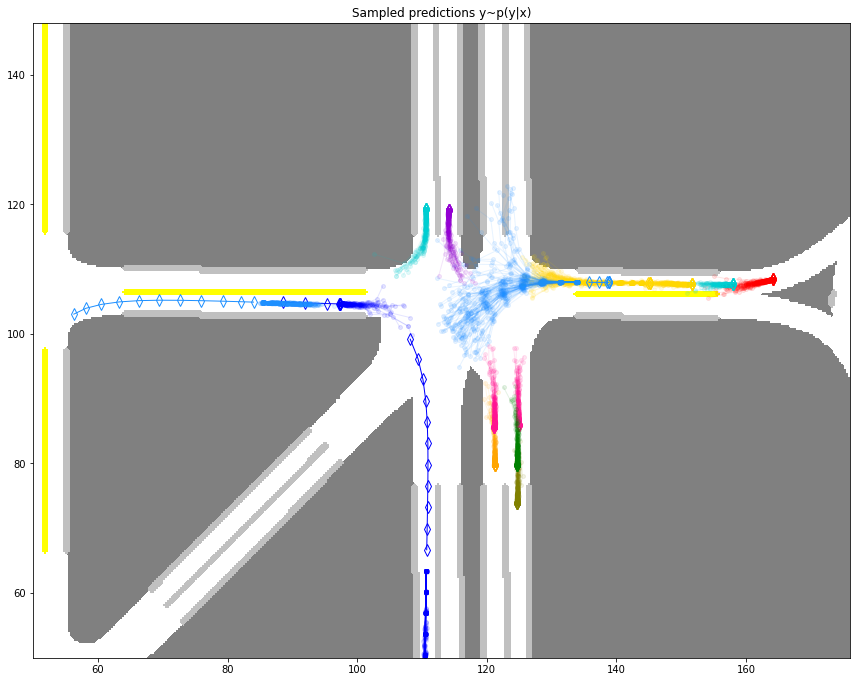

In [39]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
# v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
# node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene, is_white=True)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

#     ax.plot(player_future[:,0], player_future[:,1],
#                 marker='s', color=AGENT_COLORS[idx % NCOLORS],
#                 linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_title("Sampled predictions y~p(y|x)")
ax.set_aspect('equal')
ax.set_facecolor("grey")
        
extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([50, 50])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
fig.tight_layout()
None

### Obtain the analytical PMF of p(z|x)

Obtain the PMF of p(z|x) via tf.distribution.OneHotCategorical.probs

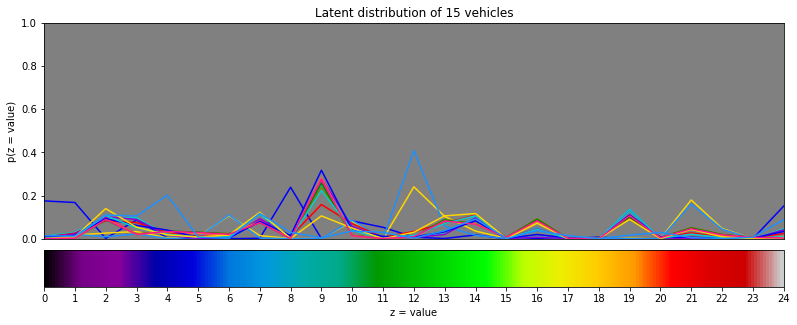

In [24]:
def generate_vehicle_latent_probs(
            z_mode=False, gmm_mode=False,
            full_dist=False, all_z_sep=False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)
    
    # model.latent is a DiscreteLatent
    # model.latent.p_dist is a tf.distribution.OneHotCategorical
    model.latent.p_dist = model.p_z_x(mode, x)
    # gets model.latent.p_dist.probs
    probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    return np.squeeze(probs, axis=1), nodes

probs, nodes = generate_vehicle_latent_probs(
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)
n_vehicles = len(nodes)

fig, ax1 = plt.subplots(figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(probs):
    ax1.plot(range(25), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
colorbar = plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

### Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x)

Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x) via GMM2D (inherits td.Distribution)

In [25]:
def generate_vehicle_gmms(
        eval_stg, scene, timesteps, ph, num_samples=100,
        z_mode=False, gmm_mode=False, full_dist=False, all_z_sep=False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    dist, _ = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    
    return dist

def cholesky_mv_gaussian(pos, mu, L, is_log_prob=False):
    """Compute the discretized PDF of a multivariate Gaussian given its Cholesky decomposition.
    Parameters
    ==========
    pos : np.array
        The coordinate points of a multidmensional cartesian grid with shape (n_x,n_y,2)
        used to retrieve the discretized PDF at those points.
        For example the pos array from a 2D cartesian grid is:
        ```
        X = np.linspace(extent[0,0], extent[0,1], N)
        Y = np.linspace(extent[1,0], extent[1,1], N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        ```
    mu : np.array
        Mean of multivariate Gaussian.
    L : np.array
        Cholesky matrix of covariance matrix Sigma of multivariate Gaussian, namely Sigma = L L^T.
    
    Returns
    =======
    np.array
        The values of the PDF at the coordinate points with shape (n_x,n_y).
    """
    n = mu.size
    L_inv = np.linalg.inv(L)
    _p = -0.5*n*np.log(2*np.pi) - np.sum(np.log(np.diag(L)))
    _w = np.einsum("jk, ...k ->...j", L_inv, pos - mu)
    _w = -0.5*np.linalg.norm(_w, axis=-1)**2
    _p = _p + _w
    if is_log_prob:
        return _p
    else:
        return np.exp(_p)

def cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls):
    _p = np.zeros(pos.shape[:2])
    for (log_pi, mu, L) in zip(log_pis, mus, Ls):
        _w = cholesky_mv_gaussian(pos, mu, L, is_log_prob=True)
        _p += np.exp(log_pi + _w)
    return _p

## Plot Distributions

Plot GMM

In [26]:
dist = generate_vehicle_gmms(
        eval_stg, scene, timesteps, ph, num_samples=1,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)

if not hyp['dynamic']['VEHICLE']['distribution']:
    node_type = eval_stg.env.NodeType.VEHICLE
    dynamic = eval_stg.node_models_dict[node_type].dynamic
    dist = dynamic.integrate_distribution(dist)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()

# assume that we are now using a mixture of Gaussians
# log_pis has shape (# vehicles, prediction_horizon, 2)
log_pis = log_pis[0,:,:]
# mus, sigmas has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:]
sigmas = sigmas[0,:,:]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:]
Ls = Ls[0,:,:]

In [27]:
node_type = eval_stg.env.NodeType.VEHICLE
dynamic = eval_stg.node_models_dict[node_type].dynamic
# dist = dynamic.integrate_distribution(dist)
dynamic

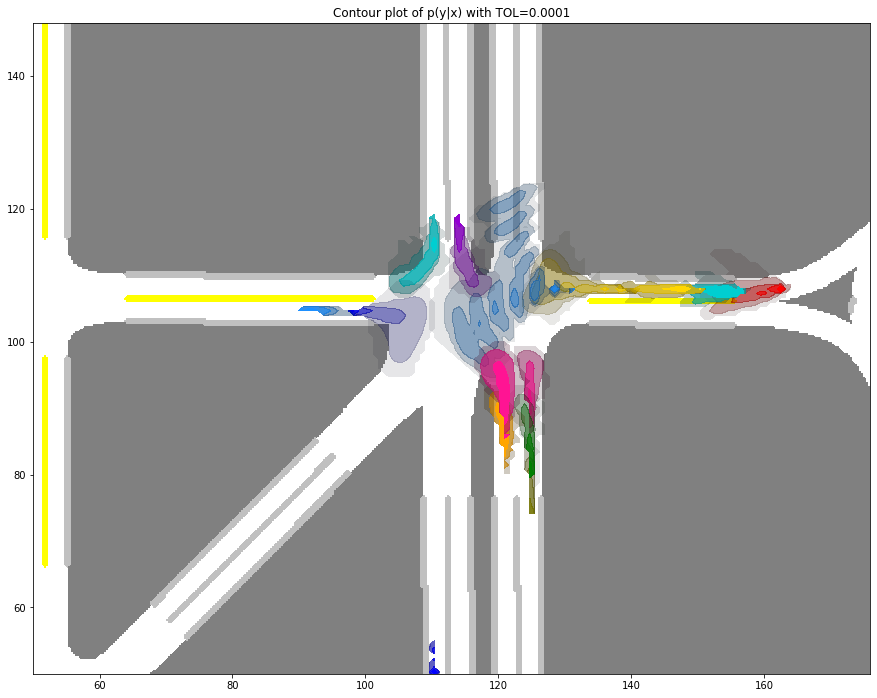

In [34]:
D = 3
extent = np.array([[0, scene.x_size], [0, scene.y_size]])
# min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
# max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
# extent = np.array([min_extent, max_extent]).T
TOL = 1e-4
N = 300
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)
extent = np.array([0, scene.x_size, 0, scene.y_size])

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
iter_ph = range(prediction_horizon)
for v_idx in iter_vehicles:
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = log_pis[v_idx,p_idx]
        vp_mus = mus[v_idx,p_idx]
        vp_Ls = Ls[v_idx,p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extent=extent, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")
ax.set_aspect('equal')
ax.set_facecolor("grey")

should_zoom_in = True
if should_zoom_in:
    zoom = np.array([50, 50])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
    ax.set_xlim([extent[0], extent[1]])
    ax.set_ylim([extent[2], extent[3]])

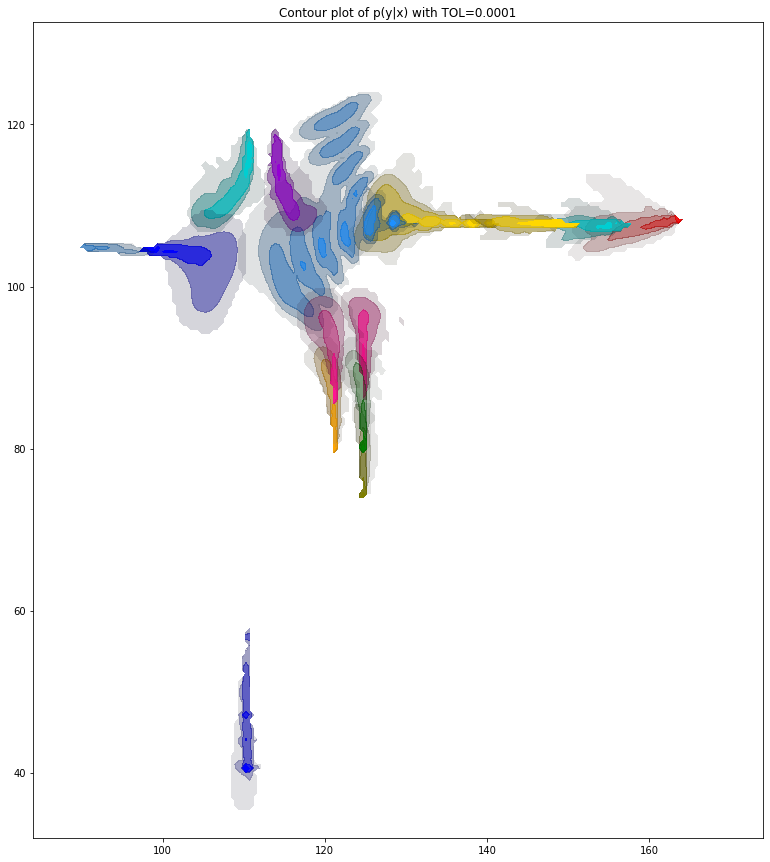

In [29]:
D = 3
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-4
N = 200
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
# render_roads(ax, scene, is_white=True)
extent = (0, scene.x_size, 0, scene.y_size)

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
# iter_vehicles = [2, 3, 4]
iter_ph = range(prediction_horizon)
# iter_ph = [4]
for v_idx in iter_vehicles:
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = log_pis[v_idx,p_idx]
        vp_mus = mus[v_idx,p_idx]
        vp_Ls = Ls[v_idx,p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    # ax.contourf(X, Y, Z, cmap=cmap, extent=extent, extend='max', locator=ticker.LogLocator())
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")
ax.set_aspect('equal')

Create an animation

In [61]:
extent = np.array([[0, scene.x_size], [0, scene.y_size]])
TOL = 1e-4
N = 300
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def get_gmm_params_at_timestep(t):
    _timesteps = np.array([t])
    dist = generate_vehicle_gmms(
            eval_stg, scene, _timesteps, ph, num_samples=1,
            z_mode=False, gmm_mode=False,
            full_dist=True, all_z_sep=False)

    if not hyp['dynamic']['VEHICLE']['distribution']:
        node_type = eval_stg.env.NodeType.VEHICLE
        dynamic = eval_stg.node_models_dict[node_type].dynamic
        dist = dynamic.integrate_distribution(dist)

    # Log Mixing Proportions
    # not used with this setting
    log_pis = dist.log_pis.cpu().detach().numpy()
    # Parameters of Gaussians
    mus = dist.mus.cpu().detach().numpy()
    sigmas = dist.sigmas.cpu().detach().numpy()
    covs = dist.get_covariance_matrix().cpu().detach().numpy()
    Ls = dist.L.cpu().detach().numpy()

    # assume that we are now using a mixture of Gaussians
    # log_pis has shape (# vehicles, prediction_horizon, 2)
    log_pis = log_pis[0,:,:]
    # mus, sigmas has shape (# vehicles, prediction_horizon, 2)
    mus = mus[0,:,:]
    sigmas = sigmas[0,:,:]
    # covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
    covs = covs[0,:,:]
    Ls = Ls[0,:,:]
    return log_pis, mus, sigmas,covs, Ls

def get_gmm_distribution_across_scene():
    # Generate GMMs for timesteps 1,2,..,scene.timesteps
    gmm_parameters = {}
    gmm_discretize = {t: [] for t in range(1, scene.timesteps)}
    def gen():
        for t in range(1, scene.timesteps):
            log_pis, mus, sigmas,covs, Ls = get_gmm_params_at_timestep(t)
            gmm_parameters[t] = (log_pis, mus, sigmas,covs, Ls)
            n_vehicles = mus.shape[0]
            prediction_horizon = mus.shape[1]
            iter_vehicles = range(n_vehicles)
            iter_ph = range(prediction_horizon)
            for v_idx in iter_vehicles:
                Zs = []
                for p_idx in iter_ph:
                    vp_log_pis = log_pis[v_idx,p_idx]
                    vp_mus = mus[v_idx,p_idx]
                    vp_Ls = Ls[v_idx,p_idx]
                    Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
                    Zs.append(Z)
                Z = np.max(Zs, axis=0)
                # Z has shape (N, N) where N is discretization
                Z = np.ma.masked_where(Z < TOL, Z)
                gmm_discretize[t].append(Z)
            yield
    for _ in tqdm(gen(), total=scene.timesteps - 1):
        pass
    return gmm_parameters, gmm_discretize

In [62]:
gmm_parameters, gmm_discretize = get_gmm_distribution_across_scene()

100%|██████████| 24/24 [11:44<00:00, 29.34s/it]


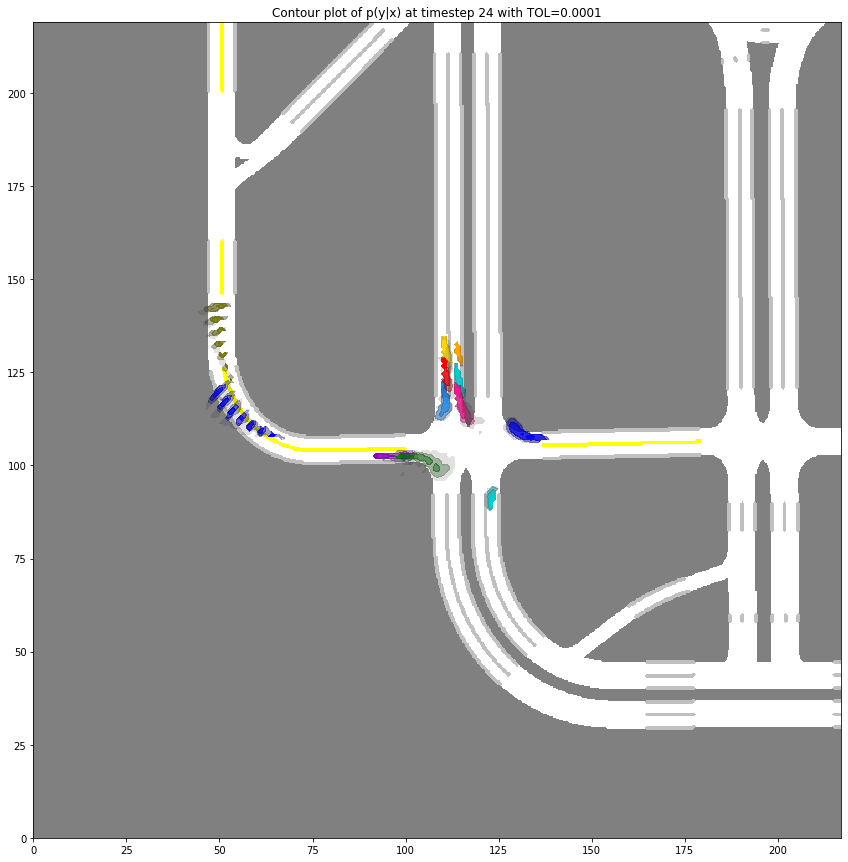

In [110]:
# Based on:
# https://stackoverflow.com/questions/43074828/remove-precedent-scatterplot-while-updating-python-animation
fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)
extent = (0, scene.x_size, 0, scene.y_size)

contours = []
contour_across_scenes = {}
def generate_cfs_for_timestep(t):
    global contours
    ax.set_title(f"Contour plot of p(y|x) at timestep {t} with TOL={TOL}")
    contour_across_scenes[t] = []
    if t == 0:
        return
    for v_idx, Z in enumerate(gmm_discretize[t]):
        cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
        cf = ax.contourf(X, Y, Z, cmap=cmap, extent=extent, extend='max', locator=ticker.LogLocator())
        contours.append(cf)
        contour_across_scenes[t].append(cf)
generate_cfs_for_timestep(0)

ax.set_aspect('equal')
ax.set_facecolor("grey")

def contourf_of_frame(t, *args):
    global contours
    for cf in contours:
        for coll in cf.collections:
            coll.remove()
    contours = []
    if t not in contour_across_scenes:
        generate_cfs_for_timestep(t)
    return contour_across_scenes[t]

# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, contourf_of_frame, frames=scene.timesteps, interval=500, blit=False, repeat=False)
writer = animation.FFMpegWriter(fps=1, codec="h264", extra_args=["-preset", "veryslow","-crf","0"])
anim.save(f"predict_contour_scene.mp4", writer=writer)
plt.show()

Plot distributions separately

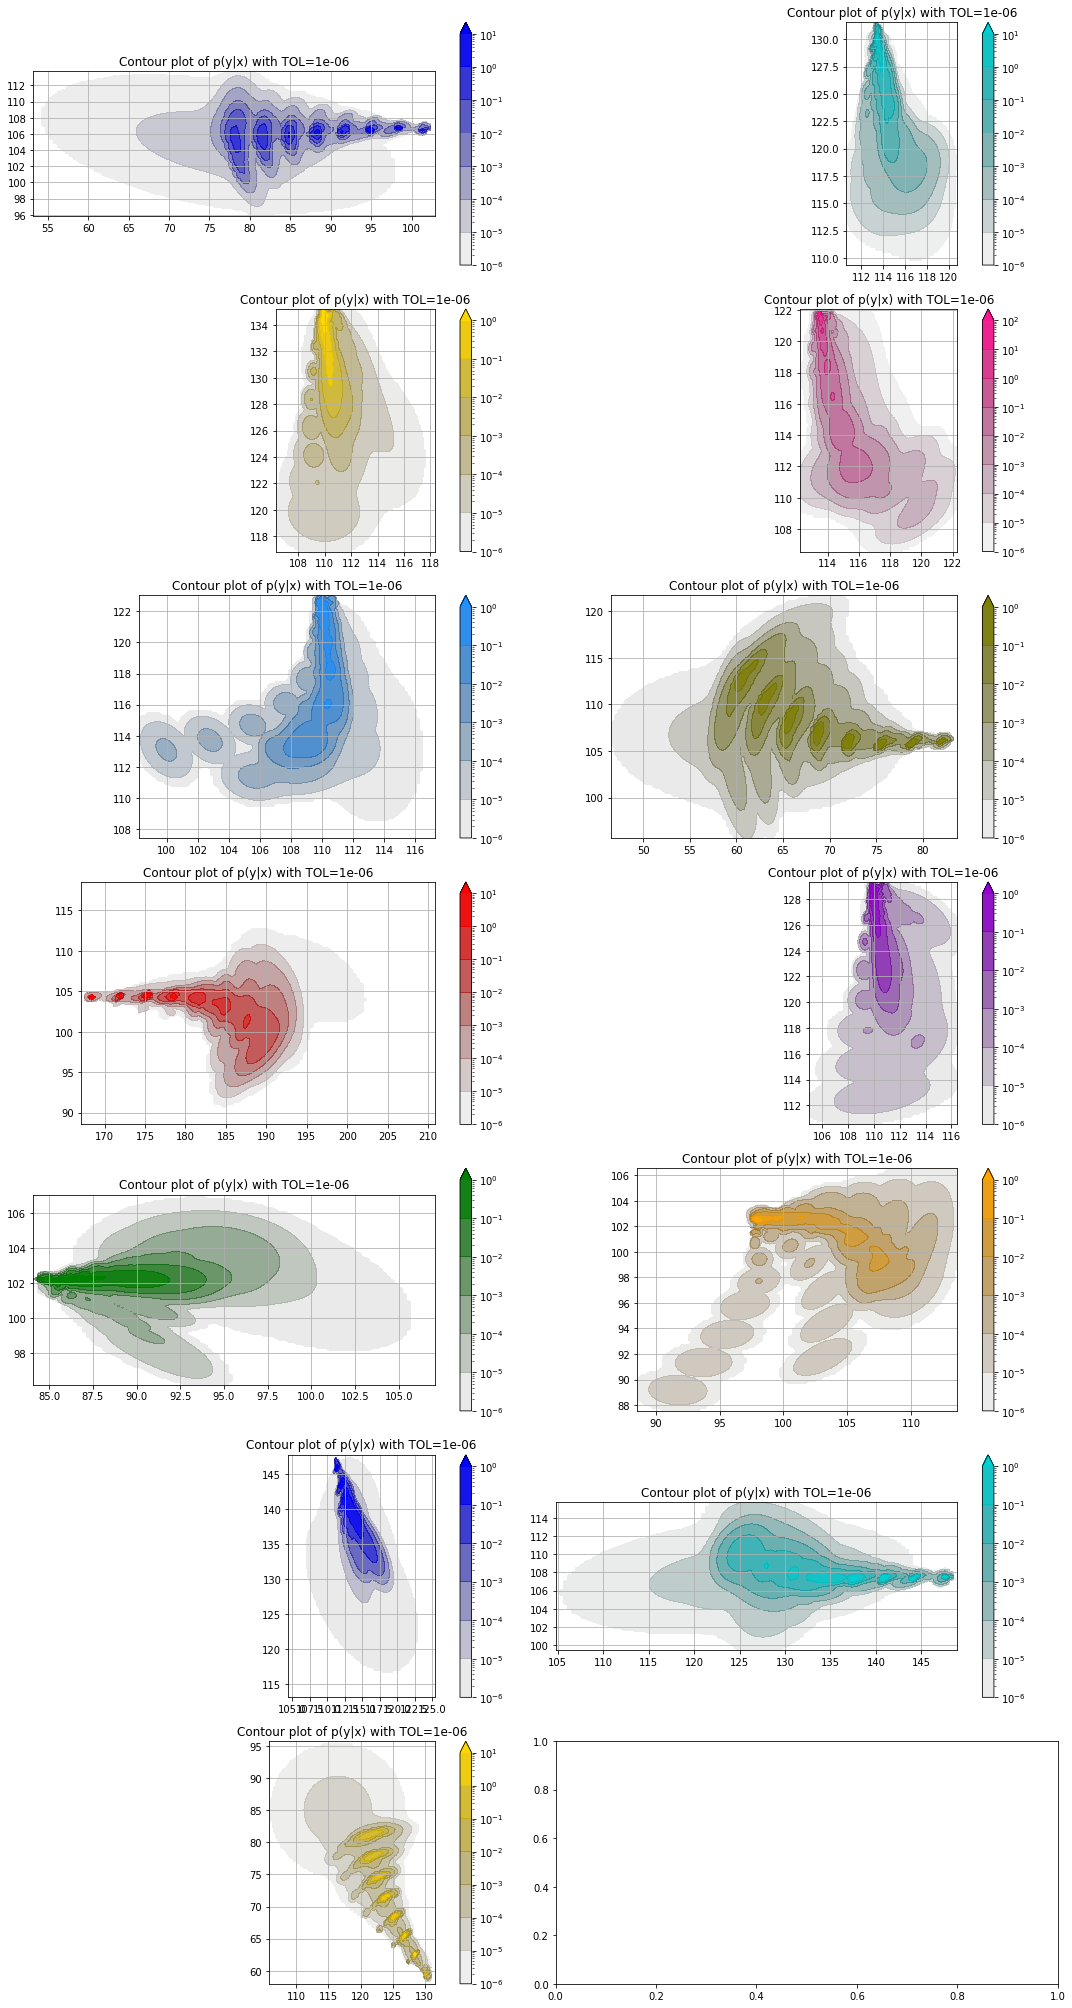

In [40]:
D = 2.5
TOL = 1e-6
N = 100
def plot_vehicle_distribution(ax, log_pis, mus, sigmas, Ls):
    min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
    max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
    extent = np.array([min_extent, max_extent]).T
    X = np.linspace(extent[0,0], extent[0,1], N)
    Y = np.linspace(extent[1,0], extent[1,1], N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    prediction_horizon = mus.shape[0]
    iter_ph = range(prediction_horizon)
    Zs = []
    for p_idx in iter_ph:
        p_log_pis = log_pis[p_idx]
        p_mus = mus[p_idx]
        p_Ls = Ls[p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, p_log_pis, p_mus, p_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    cs = ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
#     cs = ax.contour(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
#     ax.clabel(cs, cs.levels, fontsize=10)
    fig.colorbar(cs, ax=ax)
    ax.locator_params(nbins=20, axis='x')
    ax.locator_params(nbins=20, axis='y')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
    
fig, axes = plt.subplots(n_vehicles // 2 + n_vehicles % 2, 2, figsize=(15, 28))
axes = axes.ravel()

iter_vehicles = range(n_vehicles)
iter_ph = range(prediction_horizon)
for v_idx in iter_vehicles:
    v_log_pis = log_pis[v_idx]
    v_mus     = mus[v_idx]
    v_sigmas  = sigmas[v_idx]
    v_Ls      = Ls[v_idx]
    plot_vehicle_distribution(axes[v_idx], v_log_pis, v_mus, v_sigmas, v_Ls)
fig.tight_layout()

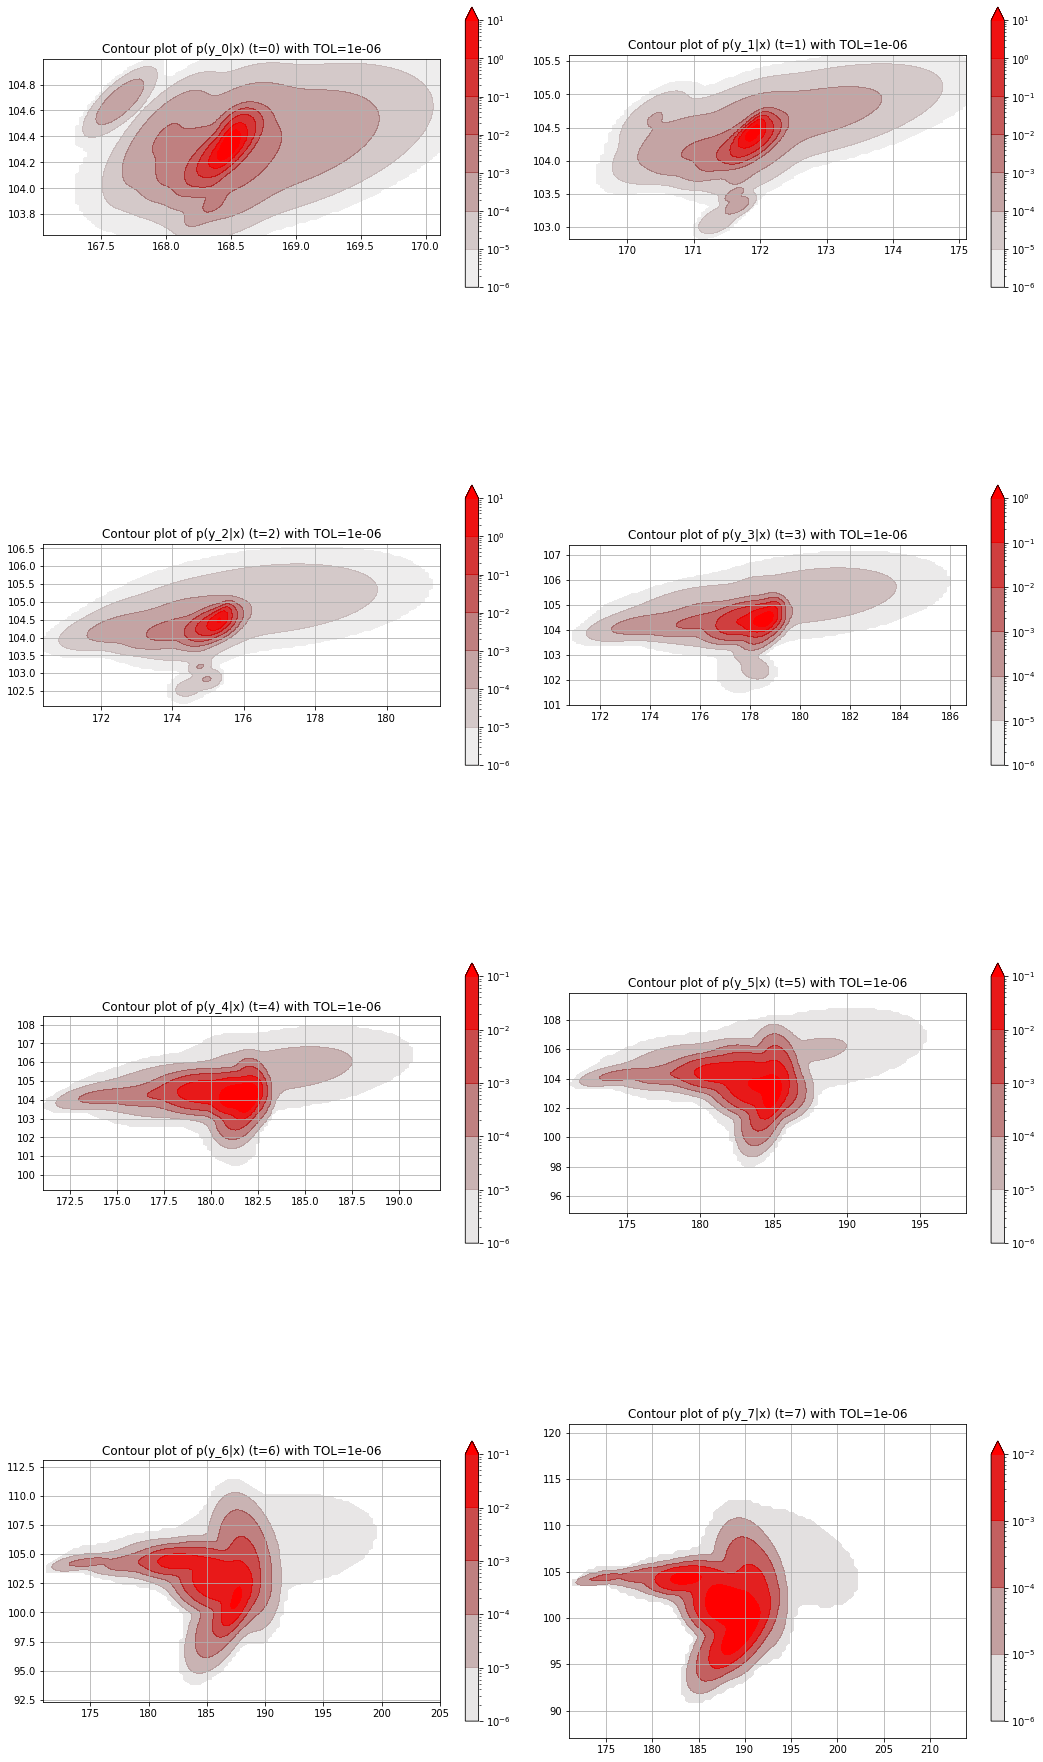

In [46]:
D = 3
TOL = 1e-6
N = 100
def plot_vehicle_distribution(ax, v_idx, t, log_pis, mus, sigmas, Ls):
    min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
    max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
    extent = np.array([min_extent, max_extent]).T
    X = np.linspace(extent[0,0], extent[0,1], N)
    Y = np.linspace(extent[1,0], extent[1,1], N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    cs = ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
#     cs = ax.contour(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
#     ax.clabel(cs, cs.levels, fontsize=10)
    fig.colorbar(cs, ax=ax, shrink=0.5)
    ax.locator_params(nbins=10, axis='x')
    ax.locator_params(nbins=10, axis='y')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title(f"Contour plot of p(y_{t}|x) (t={t}) with TOL={TOL}")

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
    
fig, axes = plt.subplots(prediction_horizon // 2 + prediction_horizon % 2, 2, figsize=(15, 28))
axes = axes.ravel()

v_idx = 6
assert v_idx < n_vehicles
for t in range(prediction_horizon):
    vp_log_pis = log_pis[v_idx, t]
    vp_mus     = mus[v_idx, t]
    vp_sigmas  = sigmas[v_idx, t]
    vp_Ls      = Ls[v_idx, t]
    plot_vehicle_distribution(axes[t], v_idx, t, vp_log_pis, vp_mus, vp_sigmas, vp_Ls)
fig.tight_layout()

Plot velocity distribution if applicable

In [20]:
dist = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()

# assume that we are now using a mixture of Gaussians
# log_pis has shape (# vehicles, prediction_horizon, 2)
log_pis = log_pis[0,:,:]
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:]
Ls = Ls[0,:,:]

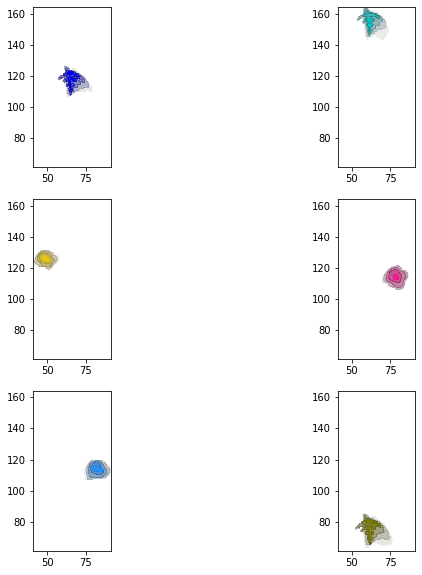

In [21]:
D = 3
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6
N = 100
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

n_vehicles = mus.shape[0]
fig, axes = plt.subplots(n_vehicles // 2, 2, figsize=(10, 10))
axes = axes.ravel()

prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
# iter_vehicles = [2, 3, 4]
iter_ph = range(prediction_horizon)
# iter_ph = [1]
for v_idx in iter_vehicles:
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = log_pis[v_idx,p_idx]
        vp_mus = mus[v_idx,p_idx]
        vp_Ls = Ls[v_idx,p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    # ax.contourf(X, Y, Z, cmap=cmap, extent=extent, extend='max', locator=ticker.LogLocator())
    axes[v_idx].contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    axes[v_idx].set_aspect('equal')

Plot single Gaussians

In [ ]:
dist = generate_vehicle_gmms(
        eval_stg, scene, timesteps, ph, num_samples=1,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

if not hyp['dynamic']['VEHICLE']['distribution']:
    node_type = eval_stg.env.NodeType.VEHICLE
    dynamic = eval_stg.node_models_dict[node_type].dynamic
    dist = dynamic.integrate_distribution(dist)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
# mus, sigmas has shape
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()
# assume that we are only using one component
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:,0]
# sigmas has shape (# vehicles, prediction_horizon, 2)
# sigmas are not used in plot
sigmas = sigmas[0,:,:,0]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:,0]
Ls = Ls[0,:,:,0]

In [ ]:
# contour plot all Gaussian's together
# uses numerically stable multivariate Gaussian based on Cholesky decomposition

D = 5
extent = np.array([[0, scene.x_size], [0, scene.y_size]])
# min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
# max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
# extent = np.array([min_extent, max_extent]).T
TOL = 1e-6
N = 500
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)
extent = (0, scene.x_size, 0, scene.y_size)

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_Ls = Ls[v_idx]
    Z = None
    for p_idx in range(prediction_horizon):
        mu = v_mus[p_idx]
        L = v_Ls[p_idx]
        L_inv = np.linalg.inv(L)
        _Z = cholesky_mv_gaussian(pos, mu, L)
        Z = _Z if Z is None else np.max((Z, _Z), axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, extent=extent, cmap=cmap, extend='max', locator=ticker.LogLocator())
    # ax.contourf(X, Y, Z, cmap=cmap, extend='max',
    #        levels=[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9])
    
ax.set_title(f"Contour plot of p(y|x,z) with TOL={TOL}")
ax.set_aspect('equal')
ax.set_facecolor("grey")